In [1]:
import pandas as pd



In [2]:
data = pd.read_csv('data.csv')

print(data.head)

<bound method NDFrame.head of                                                      url  length_url  \
0      http://outredase.bsfrweopafseekd.gdre4232r.cle...        74.0   
1                       https://tuexterior.site/empresas         NaN   
2                  http://www.drucker.com.ar/inc/aaa.htm        37.0   
3      https://cs.stackexchange.com/questions/65925/p...       121.0   
4                                       http://lohud.com         NaN   
...                                                  ...         ...   
29327                 https://maz4e25g8.icu/UyywrNmRdkR/         NaN   
29328  http://chemsbury.net/scotiabank.app.chemsbury....        87.0   
29329                             http://akcios-ujsag.hu        22.0   
29330                                  http://nestle.com         NaN   
29331                         https://txdmv.gov-tsh.win/         NaN   

       length_hostname   ip  nb_dots  nb_hyphens  nb_at  nb_qm  nb_and  nb_or  \
0                 58.0  

In [3]:
data = data.sample(frac=1, random_state=42).reset_index(drop=True)


In [4]:
import numpy as np
import re
from urllib.parse import urlparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from tqdm import tqdm

tqdm.pandas()

# Ensure 'data' is defined
# Example: data = pd.read_csv("your_file.csv")

# TF-IDF vectorizers
tfidf_word = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), max_features=300)
tfidf_char = TfidfVectorizer(analyzer='char', ngram_range=(1, 5), max_features=300)
tfidf_union = FeatureUnion([("word", tfidf_word), ("char", tfidf_char)])

# Transform TF-IDF
tfidf_features = tfidf_union.fit_transform(data['url'])
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=[
    f"tfidf_word_{i}" for i in range(tfidf_word.max_features)
] + [
    f"tfidf_char_{i}" for i in range(tfidf_char.max_features)
])

# Extract SSL feature (presence of HTTPS)
def has_ssl(url):
    return 1 if url.lower().startswith("https://") else 0

data['has_https'] = data['url'].progress_apply(has_ssl)

# Final dataset
final_df = pd.concat([
    tfidf_df.reset_index(drop=True),
    data[['status', 'has_https']].reset_index(drop=True)
], axis=1)

print("Final dataset shape:", final_df.shape)
print(final_df.head())


100%|████████████████████████████████| 29332/29332 [00:00<00:00, 1381615.40it/s]

Final dataset shape: (29332, 602)
   tfidf_word_0  tfidf_word_1  tfidf_word_2  tfidf_word_3  tfidf_word_4  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   
3           0.0           0.0           0.0           0.0           0.0   
4           0.0           0.0           0.0           0.0           0.0   

   tfidf_word_5  tfidf_word_6  tfidf_word_7  tfidf_word_8  tfidf_word_9  ...  \
0           0.0           0.0           0.0           0.0           0.0  ...   
1           0.0           0.0           0.0           0.0           0.0  ...   
2           0.0           0.0           0.0           0.0           0.0  ...   
3           0.0           0.0           0.0           0.0           0.0  ...   
4           0.0           0.0           0.0           0.0           0.0  ...   

   tfidf_char_292  tfidf_char_293 

[0 1]


/home/ravindra/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:28:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


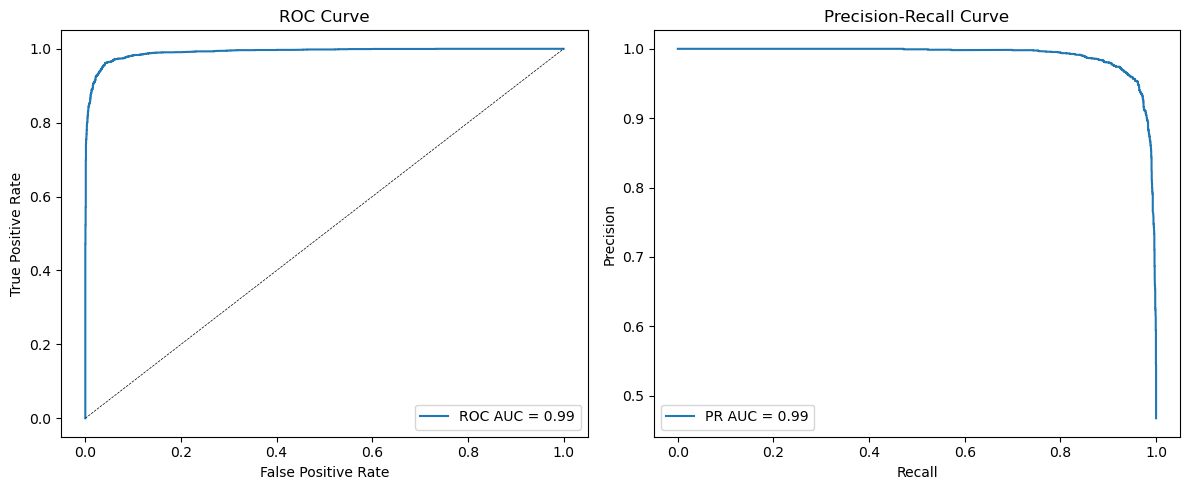

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt


label_encoder = LabelEncoder()
data['status'] = label_encoder.fit_transform(data['status'])  


vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(3, 5))
X_all = vectorizer.fit_transform(data['url'])
y = data['status']


X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=42, stratify=y)
print(np.unique(y_test))


model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

y_score = model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', linewidth=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()


precision, recall, _ = precision_recall_curve(y_test, y_score)
pr_auc = average_precision_score(y_test, y_score)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.show()


In [6]:
import re
from scipy.sparse import hstack

def predict_single_url(model, vectorizer, label_encoder):
    
    url = input("Enter a URL to test: ").strip()

    # Rule-based SSL check
    if url.lower().startswith("http://"):
        print("\nPrediction: phishing")
        print("Reason: URL does not use HTTPS (SSL is missing).")
        print("Phishing Probability: 1.0000 (heuristic rule)")
        return

    # Create DataFrameeeeeeee
    df = pd.DataFrame([url], columns=['url'])

    
    tfidf = vectorizer.transform(df['url'])

   
    pred_prob = model.predict_proba(tfidf)[0, 1]

    if pred_prob > 0.60:
        predicted_label = 'phishing'
    else:
        predicted_label = 'legitimate'

    
    print(f"\nPrediction: {predicted_label}")
    print(f"Phishing Probability: {pred_prob:.4f}")


predict_single_url(model, vectorizer, label_encoder)


Enter a URL to test:  https://gemini.google.com/app/caff60e7fc0514af



Prediction: phishing
Phishing Probability: 0.6641


<Figure size 600x500 with 0 Axes>

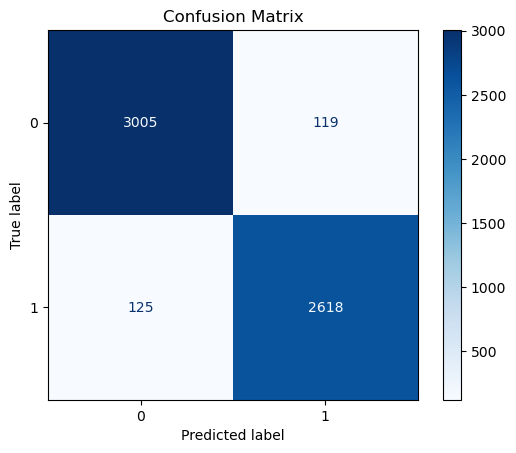

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


y_pred = model.predict(X_test)


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)


plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


In [8]:
import joblib


joblib.dump(model, 'xgb5_model.pkl')


loaded_model = joblib.load('xgb5_model.pkl')


In [9]:



joblib.dump(vectorizer, 'tfidf5_vectorizer.pkl')


['tfidf5_vectorizer.pkl']